In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import numpy as np
import torch
import os


In [26]:

# -------------------------------- 构造数据集 --------------------------------


class AdverDataset(Dataset):
    def __init__(self, root, label, transforms) -> None:
        super().__init__()
        self.root = root
        self.label = torch.from_numpy(label).long()
        self.transforms = transforms

        # 图片名称list
        self.fname = []

        for i in range(200):
            self.fname.append("{:03d}".format(i))

    def __len__(self):
        return 200

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.root, self.fname[index] + ".png"))
        img = self.transforms(img)
        label = self.label[index]
        return img, label


In [27]:

# -------------------------------- 加载模型使用 FGSM 方法攻击模型--------------------------------


class Attacker:
    def __init__(self, img_dir, label) -> None:
        super().__init__()
        self.model = models.vgg16(pretrained=True)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.mdoel = self.model.to(self.device)
        self.model.eval()
        
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        # 把图片 归一化到 0-1之间
        self.normalize = transforms.Normalize(
            self.mean, self.std, inplace=False)
        transform = transforms.Compose([
            transforms.Resize((224, 224), interpolation=3),
            transforms.ToTensor(),
            self.normalize
        ])
        self.dataset = AdverDataset(img_dir, label, transform)
        self.loader = DataLoader(self.dataset, batch_size=1, shuffle=False)

    # FGSM 攻击
    def fgsm_attack(self, image, epsilon, data_grad):
        # 找出 gradient 方向
        sign_data_grad = data_grad.sign()
        # 将图片 加上gradient方向程 epsilon noise
        perturbed_image = image + epsilon * sign_data_grad
        # 将图片超过1 或者小于0 的部分裁掉
        # perturbed_image = torch.clamp(perturbed_image, 0, 1)
        return perturbed_image

    def attack(self, epsilon):
        # 存下攻击成功样例，供展示使用
        adv_examples = []
        wrong, fail, success = 0, 0, 0
        for (data, target) in self.loader:
            data, target = data.to(self.device), target.to(self.device)
            data_raw = data
            # 输入X 一定要计算梯度
            data.requires_grad = True
            output = self.model(data)
            init_pred = output.max(1, keepdim=True)[1]

            # 如果预测错误就不进行攻击
            if init_pred.item() != target.item():
                wrong += 1
                continue

            # 如果class 正确，就计算 gradient进行攻击
            loss = F.nll_loss(output, target)
            self.model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            perturbed_data = self.fgsm_attack(data, epsilon, data_grad)

            # 再次将 noise 图片丢入 model 测试，得出对应 class
            output = self.model(perturbed_data)
            final_pred = output.max(1, keepdim=True)[1]
            if final_pred.item() == target.item():
                # 辨认结果正确，攻击失败
                fail += 1
            else:
                # 辨认结果失败，攻击成功
                success += 1
                # 保存攻击成功的图片
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data * torch.tensor(self.std, device=self.device).view(
                        3, 1, 1) + torch.tensor(self.mean, device=self.device).view(3, 1, 1)
                    adv_ex = adv_ex.squeeze().detach().cpu().numpy()
                    data_raw = data_raw * torch.tensor(self.std, device=self.device).view(
                        3, 1, 1) + torch.tensor(self.mean, device=self.device).view(3, 1, 1)
                    data_raw = data_raw.squeeze().detach().cpu().numpy()
                    adv_examples.append(
                        (init_pred.item(), final_pred.item(), data_raw, adv_ex))
        final_acc = (fail / (wrong + success + fail))
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,fail, len(self.loader), final_acc))
        return adv_examples, final_acc



In [28]:

# -------------------------------- 开始攻击--------------------------------
import os
ROOT_DIR='/home/qiyunfei/code/homework/data'
LABEL_PATH= os.path.join(ROOT_DIR,"data/labels.csv")
CATEGORY_PATH = os.path.join(ROOT_DIR,"data/categories.csv")
IMAGE_PATH = os.path.join(ROOT_DIR,"data/images")

df = pd.read_csv(LABEL_PATH)
df = df.loc[:, 'TrueLabel'].to_numpy()
label_name = pd.read_csv(CATEGORY_PATH)
label_name = label_name.loc[:, 'CategoryName'].to_numpy()
attacker = Attacker(IMAGE_PATH, df)

# 尝试的epsilon
epsilons = [0.1, 0.01]

accuracies, examples = [], []

for eps in epsilons:
    ex, acc = attacker.attack(eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.1	Test Accuracy = 6 / 200 = 0.03

Epsilon: 0.01	Test Accuracy = 54 / 200 = 0.27



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


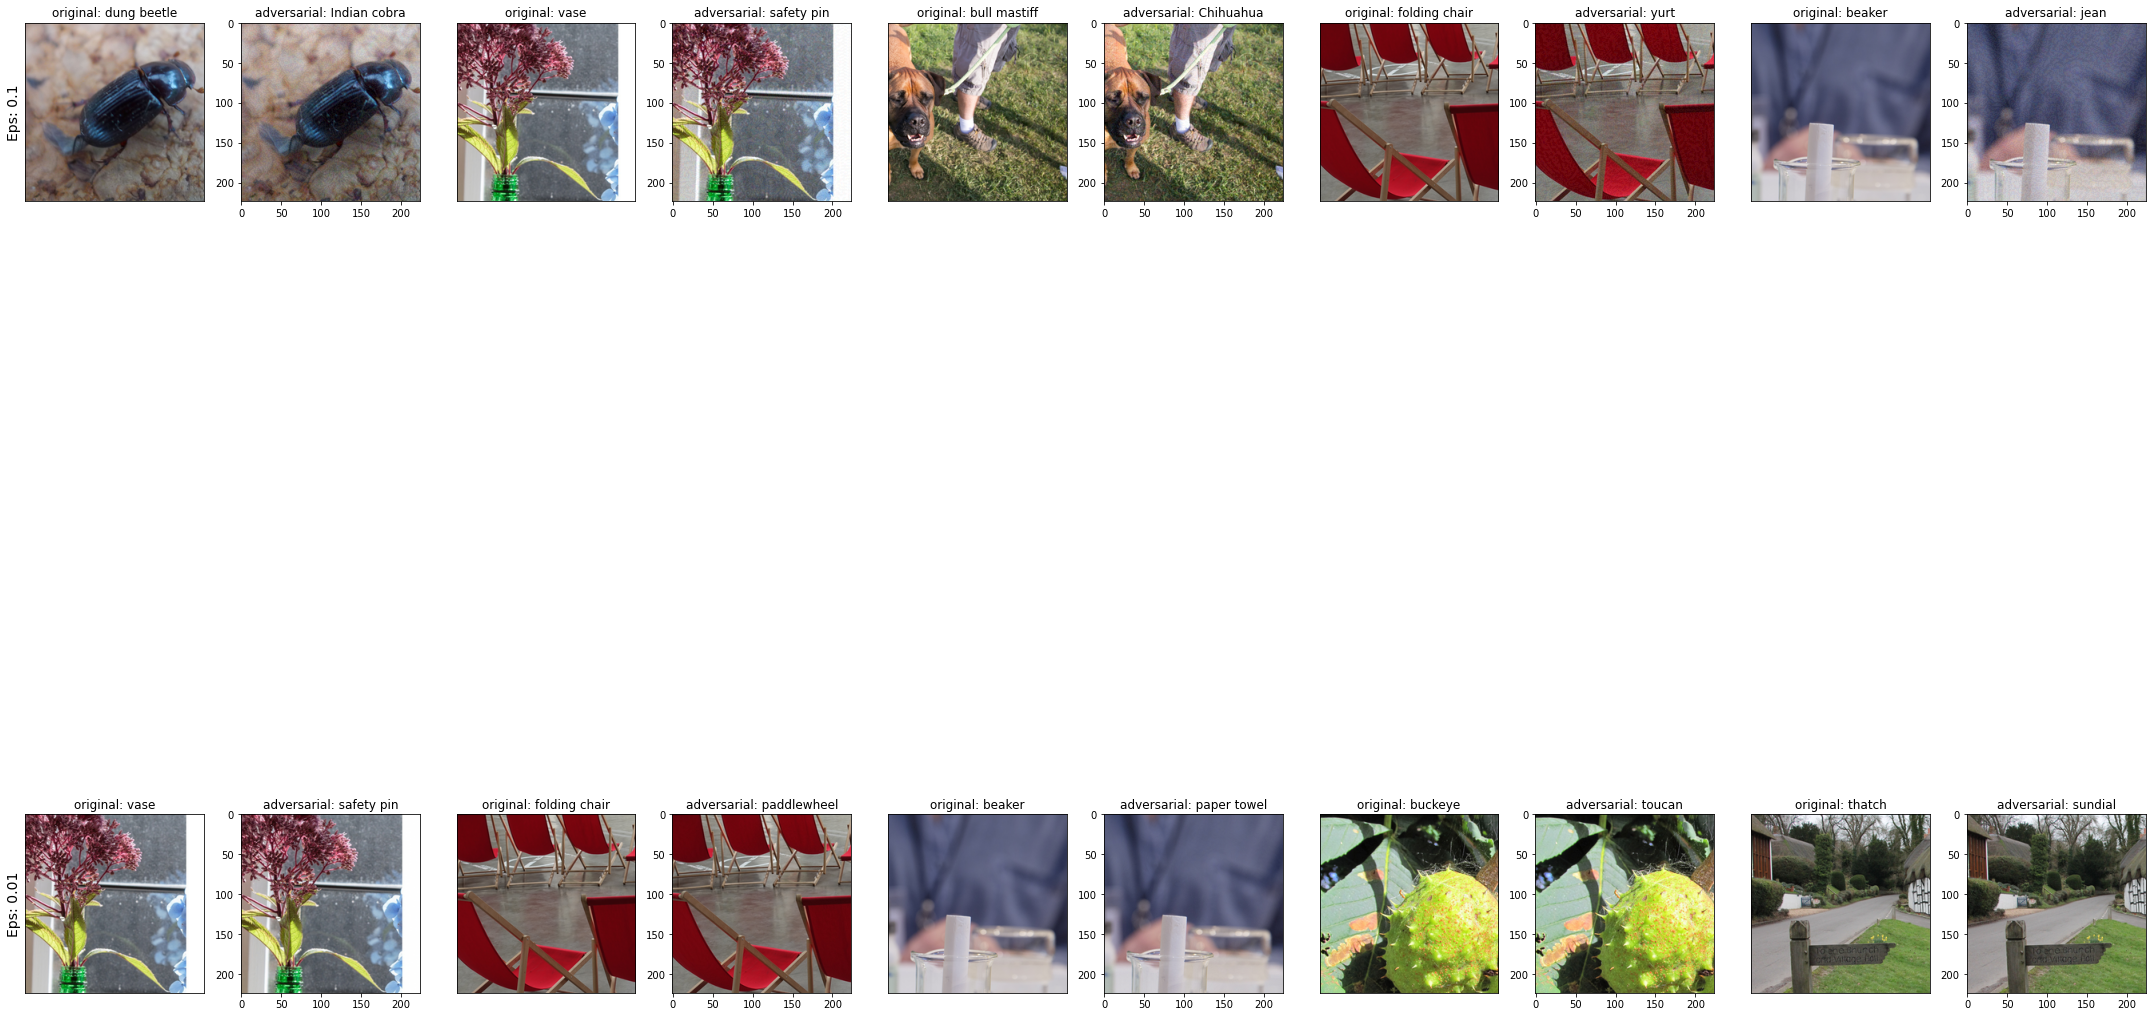

In [29]:

# -------------------------------- 攻击成功图片 --------------------------------
cnt = 0
plt.figure(figsize=(30, 30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,orig_img, ex = examples[i][j]
        # plt.title("{} -> {}".format(orig, adv))
        plt.title("original: {}".format(label_name[orig].split(',')[0]))
        orig_img = np.transpose(orig_img, (1, 2, 0))
        plt.imshow(orig_img)
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(label_name[adv].split(',')[0]))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()